In [2]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0


In [4]:
# ✅ STEP 1: Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Multiply, Conv2D, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
# Alternative to keras_focal_loss
# Simple fallback loss function due to compatibility issues
from tensorflow.keras.losses import CategoricalCrossentropy

2025-04-14 06:47:19.659875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744613239.683253     764 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744613239.690238     764 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# ✅ STEP 2: Load CSV Data
csv_path = '/kaggle/input/model2/messidor_data.csv'  
df = pd.read_csv(csv_path)
df = df.rename(columns={'id_code': 'image_path', 'diagnosis': 'dr_grade'})
df['dr_grade'] = df['dr_grade'].astype(str)

print("Loaded dataset with shape:", df.shape)
print("Class distribution:\n", df['dr_grade'].value_counts())

# ✅ STEP 3: Apply Oversampling
# Optional: Uncomment the next line and install imblearn in your environment if not already installed
#!pip install imbalanced-learn
# ✅ STEP 3: Apply Oversampling
# Optional: Uncomment the next line and install imblearn in your environment if not already installed
# !pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
df_balanced, y_balanced = ros.fit_resample(df[['image_path']], df['dr_grade'])
df_balanced['dr_grade'] = y_balanced.astype(str)
df_balanced['dr_grade'] = df_balanced['dr_grade'].astype(str)

Loaded dataset with shape: (1744, 4)
Class distribution:
 dr_grade
0    1017
2     347
1     270
3      75
4      35
Name: count, dtype: int64


In [8]:
# ✅ STEP 4: Prepare Train and Validation Sets
train_df, val_df = train_test_split(df_balanced, stratify=df_balanced['dr_grade'], test_size=0.2, random_state=42)

# ✅ STEP 5: Image Data Generators
IMG_SIZE = 300
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

image_dir = os.path.join(os.getcwd(), '/kaggle/input/model2/messidor-2/messidor-2/preprocess')  # 🔁 Replace with full path to your image directory if needed

train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_path',
    y_col='dr_grade',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_path',
    y_col='dr_grade',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4068 validated image filenames belonging to 5 classes.
Found 1017 validated image filenames belonging to 5 classes.


In [9]:
# ✅ STEP 6: Define Spatial Attention Block
class SpatialAttention(Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        attention = self.conv(concat)
        return Multiply()([x, attention])

# ✅ STEP 7: Build Model with EfficientNetB3
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[-50:]:
    layer.trainable = True

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = SpatialAttention()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1744613574.904913     764 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744613574.905612     764 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention (SpatialAttention) │ (None, 10, 10, 1536)        │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           7,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,791,319 (41.17 MB)

 Trainable params: 10,704,016 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
# ✅ STEP 8: Train Model
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3, min_lr=1e-6)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744613702.021462     834 service.cc:148] XLA service 0x79ebc0112c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744613702.021510     834 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744613702.021516     834 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744613710.028445     834 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744613729.390307     834 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

 27/128 ━━━━━━━━━━━━━━━━━━━━ 1:26 861ms/step - accuracy: 0.2869 - loss: 1.5740

E0000 00:00:1744613804.475259     836 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744613804.611198     836 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


128/128 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.4571 - loss: 1.3263 - val_accuracy: 0.2006 - val_loss: 1.6414 - learning_rate: 3.0000e-04
Epoch 2/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 128s 953ms/step - accuracy: 0.7048 - loss: 0.9073 - val_accuracy: 0.2006 - val_loss: 1.7747 - learning_rate: 3.0000e-04
Epoch 3/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 128s 951ms/step - accuracy: 0.7955 - loss: 0.7791 - val_accuracy: 0.2016 - val_loss: 2.3355 - learning_rate: 3.0000e-04
Epoch 4/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 127s 947ms/step - accuracy: 0.8066 - loss: 0.7559 - val_accuracy: 0.2527 - val_loss: 2.3829 - learning_rate: 3.0000e-04
Epoch 5/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 126s 940ms/step - accuracy: 0.8520 - loss: 0.6741 - val_accuracy: 0.3451 - val_loss: 1.7581 - learning_rate: 3.0000e-04
Epoch 6/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 127s 946ms/step - accuracy: 0.8958 - loss: 0.6100 - val_accuracy: 0.8328 - val_loss: 0.7049 - learning_rate: 9.0000e-05
Epoch 7/60
128/128 ━━━━━━━━━━━━━━━━━━━━ 128s 947ms/ste

In [11]:
# ✅ STEP 9: Evaluate
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 116s 904ms/step - accuracy: 0.9992 - loss: 0.3986
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.9564 - loss: 0.4836
Training Accuracy: 99.85%
Validation Accuracy: 95.77%


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 580ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       204
           1       0.90      0.95      0.92       203
           2       0.94      0.96      0.95       203
           3       1.00      1.00      1.00       204
           4       1.00      1.00      1.00       203

    accuracy                           0.96      1017
   macro avg       0.96      0.96      0.96      1017
weighted avg       0.96      0.96      0.96      1017



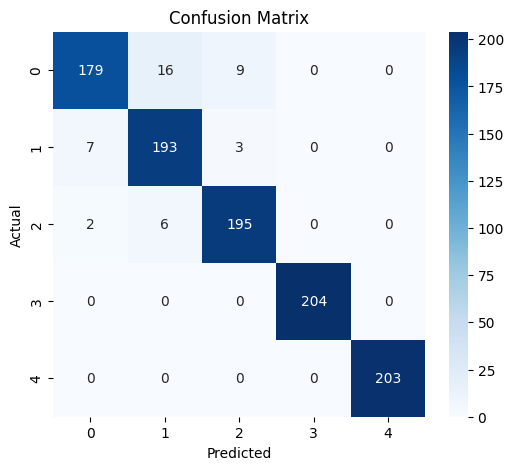

In [12]:
# ✅ STEP 10: Classification Report and Confusion Matrix
y_true = val_data.classes
y_pred = model.predict(val_data).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

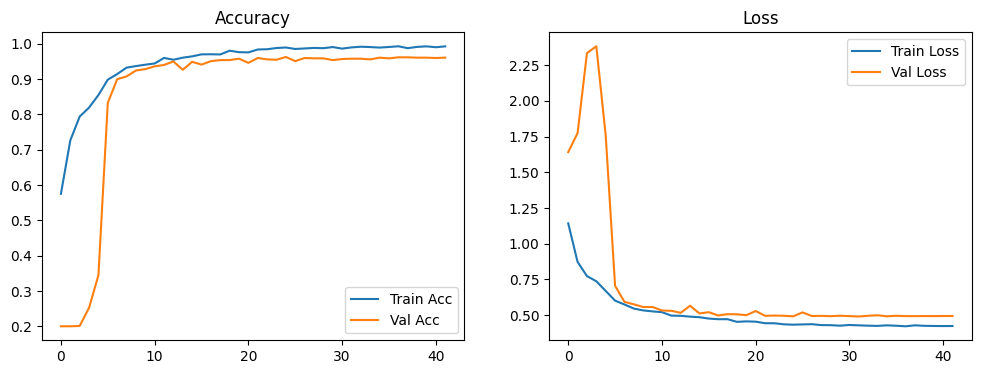

In [13]:
# ✅ STEP 11: Accuracy & Loss Plots
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()